# Проект "Прогнозирование оттока клиентов ТелеДом"

## Цель проекта
Разработка модели машинного обучения для прогнозирования оттока клиентов оператора связи "ТелеДом" с целью своевременного предложения персональных условий и удержания абонентов.

## Описание данных

### Источники данных
База данных SQLite, содержащая 4 таблицы:
1. `contract` - информация о договорах
2. `personal` - персональные данные клиентов
3. `internet` - данные об интернет-услугах
4. `phone` - данные о телефонных услугах

## Таблицы и поля

### Таблица `contract` (Договоры)
- `customerID` - Уникальный идентификатор клиента
- `BeginDate` - Дата начала действия договора
- `EndDate` - Дата расторжения договора (NULL для действующих клиентов)
- `Type` - Периодичность оплаты: "Ежемесячно" или "Ежегодно"
- `PaperlessBilling` - Использование электронных счетов (Да/Нет)
- `PaymentMethod` - Способ оплаты: "Электронный чек", "Кредитная карта" и др.
- `MonthlyCharges` - Размер ежемесячного платежа
- `TotalCharges` - Общая сумма выплат клиента

### Таблица `personal` (Персональные данные)
- `customerID` - Уникальный идентификатор клиента
- `gender` - Пол клиента
- `SeniorCitizen` - Пенсионный статус
- `Partner` - Наличие супруга/супруги
- `Dependents` - Наличие детей

### Таблица `internet` (Интернет-услуги)
- `customerID` - Уникальный идентификатор клиента
- `InternetService` - Тип подключения
- `OnlineSecurity` - Подписка на интернет-безопасность
- `OnlineBackup` - Подписка на облачное резервное копирование
- `DeviceProtection` - Антивирус
- `TechSupport` - Техническая поддержка
- `StreamingTV` - Стриминговое ТВ
- `StreamingMovies` - Каталог фильмов

### Таблица `phone` (Телефонные услуги)
- `customerID` - Уникальный идентификатор клиента
- `MultipleLines` - Подключение телефона к нескольким линиям одновременно.

## Особенности данных
- Данные актуальны на 1 февраля 2020 года

## Задачи анализа
1. Определить ключевые факторы оттока клиентов
2. Построить прогнозную модель ухода абонентов
3. Выделить сегменты клиентов с высоким риском оттока
4. Разработать рекомендации по удержанию клиентов

# План:
1. Проверить доступность базы данных. Исследовать таблицы с данными на наличие данных и соотвествие полей указанных в ТЗ.
2. Выгрузить данные из таблиц в датафреймы и по очереди изучить данные в них.
3. Объеденить полученные датафреймы и провести анализ признаков на полном наборе данных.
4. Провести корреляционный анализ, при необходимости удалить / создать новые признаки.
5. Выбрать модели, подготовить данные и провести обучение.
6. Определить лучшую модель, протестировать и построить визуализации ее работы.
7. Изсследовать важность признаков
8. Написать финальный вывод, рекомендации

In [3]:
# установка модулей
!pip install phik -q
!pip install scikit-learn==1.6.0 -q
!pip install shap -q
!pip install matplotlib==3.9.2 -q

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import pandas as pd
import phik
import random
import seaborn as sns
import shap
import tensorflow as tf
import urllib.request

from catboost import CatBoostClassifier, Pool
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from tabulate import tabulate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    Input,
)
from tensorflow.keras.models import Sequential

In [5]:
# объявление констант
DB_PATH = "data/"
DB_FILE = "ds-plus-final.db"
DB_URL = "https://code.s3.yandex.net/data-scientist/ds-plus-final.db"
DB_TABLE_NAMES = ['contract', 'personal', 'internet', 'phone']
DB_TABLE_DICT = {
    "contract": [
        "customerID",
        "BeginDate",
        "EndDate",
        "Type",
        "PaperlessBilling",
        "PaymentMethod",
        "MonthlyCharges",
        "TotalCharges"
    ],
    "personal": [
        "customerID",
        "gender",
        "SeniorCitizen",
        "Partner",
        "Dependents"
    ],
    "internet": [
        "customerID",
        "InternetService",
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies"
    ],
    "phone": [
        "customerID",
        "MultipleLines"
    ]
}                  
RANDOM_STATE = 110825
TEST_SIZE = .25
TARGET_METRIC = .85
TARGET = "IsCancel"

In [6]:
# настройка стиля графиков
sns.set(style="whitegrid", palette="pastel")

# 1. Первичный осмотр данных

In [8]:
# создаем каталог для хранения БД
if not os.path.exists(DB_PATH):
    try:
        os.makedirs(DB_PATH)
        print(f"Каталог {DB_PATH} создан")
    except Exception as err:
        print(f"Ошибка при создании каталога 'data': {err}")

In [9]:
# загружаем файл с БД
if not os.path.exists(DB_PATH+DB_FILE):
    try:
        urllib.request.urlretrieve(DB_URL, DB_PATH+DB_FILE)
        print(f"База данных {DB_FILE} загружена")
    except Exception as err:
        print(f"Ошибка при попытке загрузки базы данных {err}")
else:
    print(f"База данных {DB_FILE} уже загружена")

База данных ds-plus-final.db уже загружена


In [10]:
# подключаемся к БД
engine = create_engine(f'sqlite:///{DB_PATH+DB_FILE}', echo=False) 

### TableGetInfo

Класс для проверки структуры и анализа данных в таблицах базы данных.

### Основной функционал

- Валидация структуры таблиц (соответствие ожидаемым столбцам)
- Анализ метаинформации (типы данных, NULL-значения)
- Подсчет уникальных значений
- Просмотр образцов данных

### Конструктор класса
`__init__(self, engine, tables_dict=None)` - Инициализирует анализатор с подключением к БД и словарем таблиц.

### Внутренние методы

`_get_table_info(table_name)` - Получает метаинформацию о структуре указанной таблицы.

`_check_null_values(table_name)` - Подсчитывает количество NULL-значений для каждого столбца таблицы.

`_get_table_size(table_name)` - Считает общее количество строк в указанной таблице.

`_unique_counts(table_name, columns)` - Вычисляет количество уникальных значений для указанных столбцов.

`_validate_tables()` - Основной метод валидации, проверяет все таблицы из словаря.

### Публичные методы

`print_info()` - Выводит форматированный отчет о структуре таблиц и их данных.

`show_data(limit=5)` - Отображает первые N строк из каждой таблицы для предварительного просмотра.

In [12]:
class TableGetInfo:
    def __init__(self, engine, tables_dict=None):
        if not tables_dict:
            raise ValueError('Словарь tables_dict не может быть пустым')
        self.engine = engine
        self.tables_dict = tables_dict
        self.results = {}
        self._validate_tables()
    
    def _get_table_info(self, table_name):
        try:
            query = text(f"PRAGMA table_info({table_name})")
            return pd.read_sql_query(query, con=self.engine)
        except SQLAlchemyError as e:
            print(f"Ошибка при получении информации о таблице {table_name}: {e}")
            return None
            
    def _check_null_values(self, table_name):
        null_counts = {}
        try:
            for column in self.tables_dict[table_name]:
                query = text(f"SELECT COUNT(*) FROM {table_name} WHERE {column} IS NULL")
                null_count = pd.read_sql_query(query, self.engine).iloc[0, 0]
                if null_count > 0:
                    null_counts[column] = null_count
        except SQLAlchemyError as e:
            print(f"Ошибка при проверке NULL-значений в {table_name}.{column}: {e}")
        return null_counts
        
    def _get_table_size(self, table_name):
        query = text(f'SELECT COUNT(*) FROM {table_name}')
        try:
            return pd.read_sql_query(query, con=self.engine).iloc[0,0]
        except SQLAlchemyError as e:
            print(f"Ошибка при выполнении запроса: {e}")
            return None
            
    def _unique_counts(self, table_name, columns):
        value_counts = {}
        for col in columns:
            query = text(f"SELECT COUNT(DISTINCT UPPER({col})) FROM {table_name}")
            value_counts[col] = pd.read_sql_query(query, engine).iloc[0,0]
        return value_counts
        
    def _validate_tables(self):        
        for table_name, expected_columns in self.tables_dict.items():
            actual_info = self._get_table_info(table_name)
            actual_columns = actual_info['name'].tolist()
            missing_in_db = set(expected_columns) - set(actual_columns)
            extra_in_db = set(actual_columns) - set(expected_columns)
            self.results[table_name] = {
                'status': 'ok' if not missing_in_db and not extra_in_db else 'mismatch',
                'table_size': self._get_table_size(table_name),
                'actual_columns': actual_columns,
                'value_counts': self._unique_counts(table_name, actual_columns),
                'missing_columns': list(missing_in_db),
                'extra_columns': list(extra_in_db),
                'column_types': dict(zip(actual_info['name'], actual_info['type'])),
                'null_values': self._check_null_values(table_name)
            }

    def print_info(self):
        for table_name, data in self.results.items():
            print(f"\nТаблица: {table_name}")
            print("-" * 50)
            
            if data['status'] == 'ok':
                print("✅ Структура полностью соответствует ожидаемой")
            else:
                if data['missing_columns']:
                    print(f"❌ Отсутствующие столбцы: {', '.join(data['missing_columns'])}")
                if data['extra_columns']:
                    print(f"❌ Лишние столбцы в БД: {', '.join(data['extra_columns'])}")

            print(f"\nКоличество строк: {data['table_size']}")
          
            if data['null_values']:
                print("\nПропущенные значения (NULL):")
                for col, count in data['null_values'].items():
                    print(f"  - {col}: {count} пропусков")
            else:
                print("\nПропусков(NULL) нет")
                    
            print("\nПроверка столбцов, типов и уникальных значений:")
            for col in data['actual_columns']:
                status = "🔴" if col in data['missing_columns'] or col in data['extra_columns'] else "🟢"
                col_type = data['column_types'].get(col)
                value_counts = data['value_counts'].get(col)
                print(f"{status} {col}: {col_type}: {value_counts}")            
            print("-" * 50)

    def show_data(self, limit=5):
        for table_name in self.tables_dict.keys():
            try:
                query = text(f"SELECT * FROM {table_name} LIMIT {limit}")
                df = pd.read_sql_query(query, self.engine)
                
                print(f"\n{'-'*50}")
                print(f"Таблица: {table_name} (первые {limit} записей)")
                print('-'*50)
                print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

            except Exception as e:
                print(f"\nОшибка при обработке таблицы {table_name}: {str(e)}")

In [13]:
# инициализация 
analyzer = TableGetInfo(engine=engine, tables_dict=DB_TABLE_DICT)

In [14]:
# запуск валидаци таблиц БД
analyzer.print_info()


Таблица: contract
--------------------------------------------------
✅ Структура полностью соответствует ожидаемой

Количество строк: 7043

Пропусков(NULL) нет

Проверка столбцов, типов и уникальных значений:
🟢 customerID: TEXT: 7043
🟢 BeginDate: TEXT: 77
🟢 EndDate: TEXT: 67
🟢 Type: TEXT: 3
🟢 PaperlessBilling: TEXT: 2
🟢 PaymentMethod: TEXT: 4
🟢 MonthlyCharges: TEXT: 1585
🟢 TotalCharges: TEXT: 6658
--------------------------------------------------

Таблица: personal
--------------------------------------------------
✅ Структура полностью соответствует ожидаемой

Количество строк: 7043

Пропусков(NULL) нет

Проверка столбцов, типов и уникальных значений:
🟢 customerID: TEXT: 7043
🟢 gender: TEXT: 2
🟢 SeniorCitizen: TEXT: 2
🟢 Partner: TEXT: 2
🟢 Dependents: TEXT: 2
--------------------------------------------------

Таблица: internet
--------------------------------------------------
✅ Структура полностью соответствует ожидаемой

Количество строк: 5517

Пропусков(NULL) нет

Проверка столбц

In [15]:
analyzer.show_data()


--------------------------------------------------
Таблица: contract (первые 5 записей)
--------------------------------------------------
+--------------+-------------+-----------+----------------+--------------------+---------------------------+------------------+----------------+
| customerID   | BeginDate   | EndDate   | Type           | PaperlessBilling   | PaymentMethod             |   MonthlyCharges |   TotalCharges |
|--------------+-------------+-----------+----------------+--------------------+---------------------------+------------------+----------------|
| 7590-VHVEG   | 2020-01-01  | No        | Month-to-month | Yes                | Electronic check          |            29.85 |          31.04 |
| 5575-GNVDE   | 2017-04-01  | No        | One year       | No                 | Mailed check              |            56.95 |        2071.84 |
| 3668-QPYBK   | 2019-10-01  | No        | Month-to-month | Yes                | Mailed check              |            53.85 |        

## Выводы по разделу:
1. Реализован класс `TableGetInfo` для анализа структуры БД.
2. Настроена проверка соответствия ожидаемой и фактической структуры таблиц.
3. Все таблицы нужные для анализа присутствуют, не пустые, пропусков при первичном остмотре не выявлено.
4. Все данные имеют тип `TEXT`, что не совсем корректно. После записи данных в датафреймы нужно будеи изменить типы на подходящие.
5. В таблице `phone` поле с идентификатором клиента, имеет написание отличное от ожидаемого (неверный регистр букв), его нужно будет переименовать.
6. При осмотре установлено, что количество записей в каждой таблице соотвествует количеству уникальных клиентов, т.е. дублей клиентов нет.

## 2. Исследование данных

## Таблица contract

In [19]:
# подготовим запрос
query = '''
SELECT 
    *
FROM 
    contract
'''

In [20]:
# загрузим необходимые данные в датафрейм
df_contract = pd.read_sql_query(query, con = engine)

Необходимо сделать преобразования:
* Конвертировать `BeginDate` в datetime
* Создать признака `IsCancel` (0/1), закрыт ли договор или еще действует
* Заменить **No** в `EndDate` на `2020-02-01` и конвертировать в datetime
* Расчитать `DaysActive`, разница дат между началом действия довора и его завершением
* Конвертировать `MonthlyCharges`, `TotalCharges` во float

In [22]:
# преобразование BeginDate в datetime формат с обработкой возможных ошибок
try:
    df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
except Exception as err:
    print(f'Ошибка конвертиции типа признака BeginDate {err}')

# создание признака отмены контракта (1 - отменен, 0 - активен)
df_contract['IsCancel'] = df_contract['EndDate'].apply(lambda x: 0 if x == "No" else 1)

# обработка EndDate, замена значения "No" на "2020-02-01" и преобразование в datetime
try:
    df_contract['EndDate'] = df_contract['EndDate'].replace("No", "2020-02-01")
    df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])
except Exception as err:
    print(f'Ошибка конвертиции типа признака EndDate {err}')

# расчет количества активных дней контракта
df_contract['DaysActive'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days

# преобразование MonthlyCharges в float
try:
    df_contract['MonthlyCharges'] = df_contract['MonthlyCharges'].astype(float)
except Exception as err:
    print(f'Ошибка конвертиции типа признака MonthlyCharges {err}')

# преобразование TotalCharges в float
try:
    df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)
except Exception as err:
    print(f'Ошибка конвертиции типа признака TotalCharges {err}')

Ошибка конвертиции типа признака TotalCharges could not convert string to float: ' '


В признаке `TotalCharges` обнаружены нечисловые значения " "

In [24]:
# замена пробелов на NaN
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace(' ', np.nan)
df_contract[df_contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsCancel,DaysActive
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Как видим, пустые значения возникли от того, что договоры офомлены датой выборки и у клиентов еще не сформировалось поле `TotalCharges`. Приравняем это поле к `MonthlyCharges`.

In [26]:
# заполняем пропуски соответсвующими значениями MonthlyCharges
df_contract.loc[df_contract['TotalCharges'].isna(), 'TotalCharges'] = df_contract.loc[df_contract['TotalCharges'].isna(), 'MonthlyCharges']

In [27]:
# повторно проводим приведение типов
try:
    df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)
except Exception as err:
    print(f'Ошибка конвертиции типа признака TotalCharges {err}')

In [28]:
# посмотрим на фрагмент данных
df_contract.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsCancel,DaysActive
2660,5639-NTUPK,2019-01-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),52.10,704.39,0,396
4192,7137-NAXML,2018-03-01,2020-02-01,One year,No,Bank transfer (automatic),20.15,477.35,0,702
2925,2931-XIQBR,2015-12-01,2020-02-01,One year,No,Mailed check,103.05,5152.50,0,1523
2203,4815-YOSUK,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),104.90,7552.80,0,2191
2516,8245-UMPYT,2018-06-01,2020-02-01,Month-to-month,Yes,Electronic check,96.40,1985.84,0,610
4462,6087-MVHJH,2018-07-01,2020-02-01,Month-to-month,Yes,Electronic check,88.45,1680.55,0,580
4660,0883-EIBTI,2019-10-01,2020-02-01,Month-to-month,No,Mailed check,19.50,78.00,0,123
3590,9447-YPTBX,2015-12-01,2019-11-01,One year,Yes,Bank transfer (automatic),19.85,960.94,1,1431
3418,4176-FXYBO,2015-08-01,2020-02-01,Month-to-month,No,Electronic check,109.55,5915.70,0,1645
6269,2946-KIQSP,2017-03-01,2020-02-01,Month-to-month,Yes,Mailed check,33.45,1170.75,0,1067


### Визуализация распределения признаков

In [30]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'IsCancel']

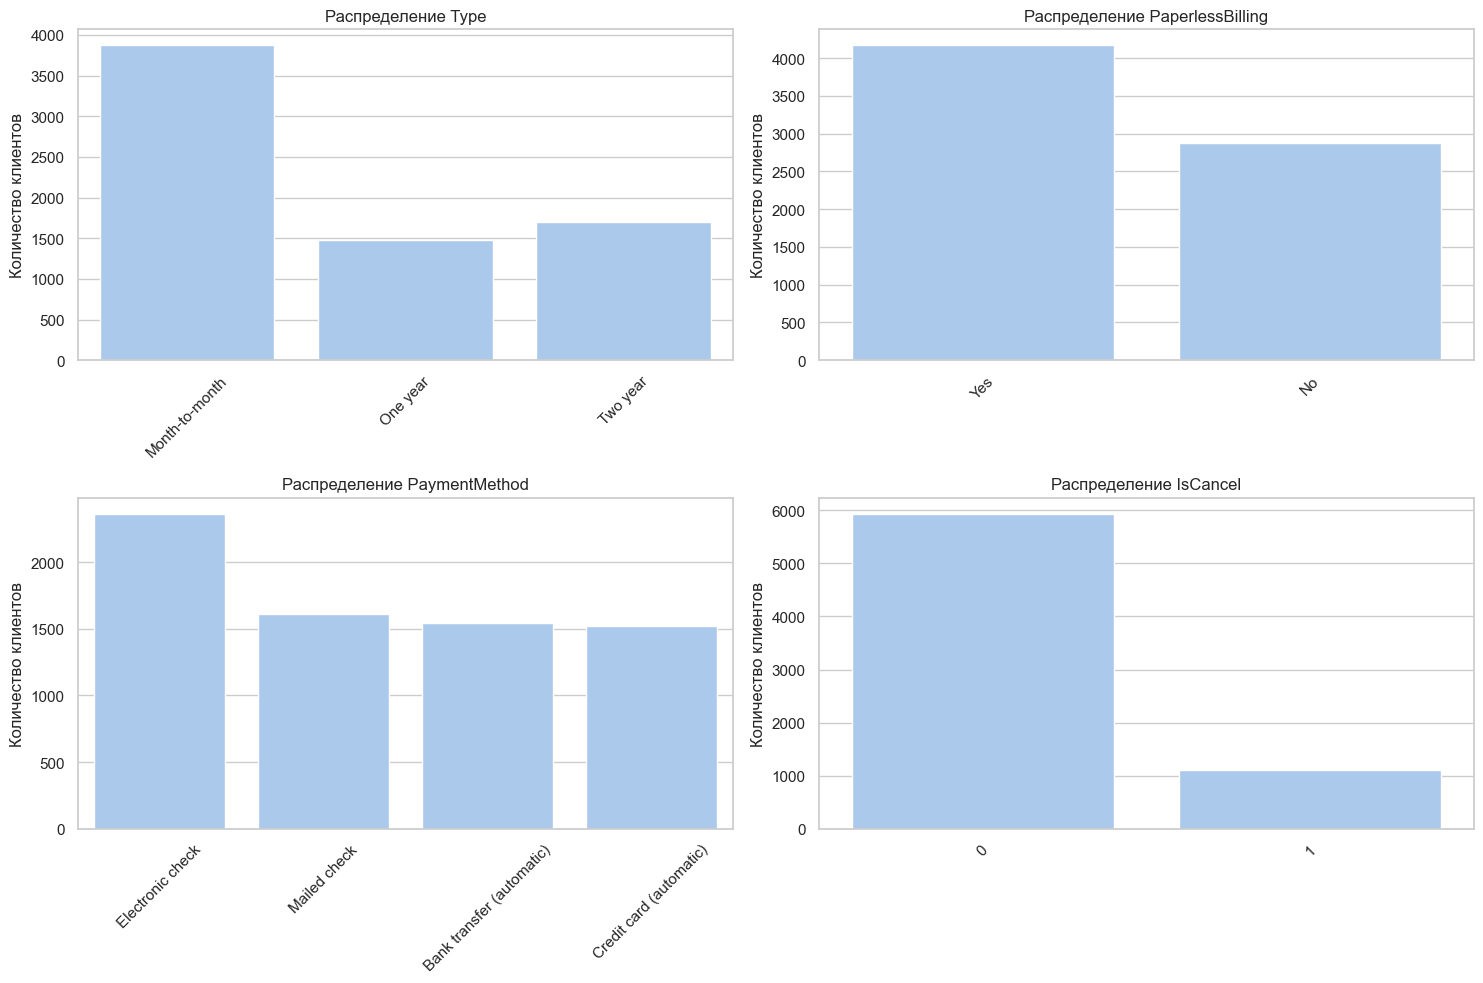

In [31]:
# распределение категориальных признаков
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df_contract, x=feature),#, hue='IsCancel')
    plt.title(f'Распределение {feature}')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

* больше половины всех договоров оформляется с помесячной оплатой
* в целевом признаке наблюдается дисбаланс, отмененных доворов значительно меньше чем действующих

In [33]:
numeric_features = ['MonthlyCharges', 'TotalCharges', 'DaysActive']

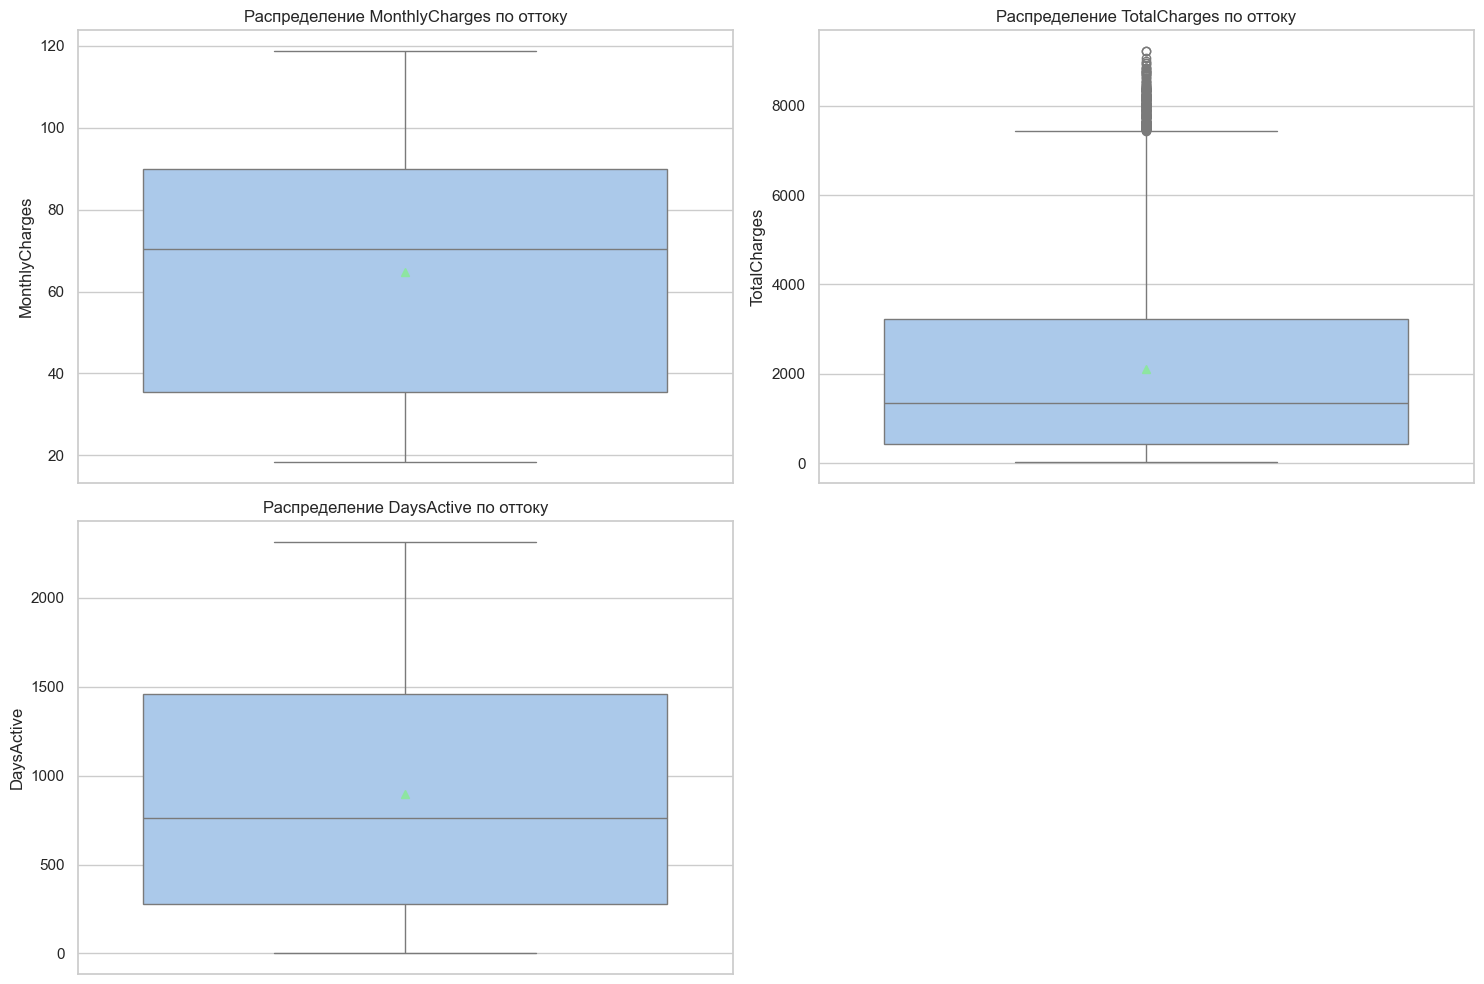

In [34]:
# распределение количественных признаков
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df_contract, y=feature, showmeans=True) # , x='IsCancel'
    plt.title(f'Распределение {feature} по оттоку')
    # plt.xlabel('Отток (0 - активен, 1 - отменил)')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

* признаки `MonthlyCharges` и `DaysActive` имеею распределение близкое к нормальному, без выбросов
* признак `TotalyCharges` имеет выбросы в виде сумм более 7500, предположительно это самые первые клиенты

## Таблица personal

In [37]:
# подготовим запрос
query = '''
SELECT 
    *
FROM 
    personal
'''

In [38]:
# загрузим необходимые данные в датафрейм
df_personal = pd.read_sql_query(query, con = engine)

Никаких преобразований делать не будем. Признак `SeniorCitizen` хоть и представлен цифрами, по сути это категориальный признак.

### Визуализация распределения признаков

In [41]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

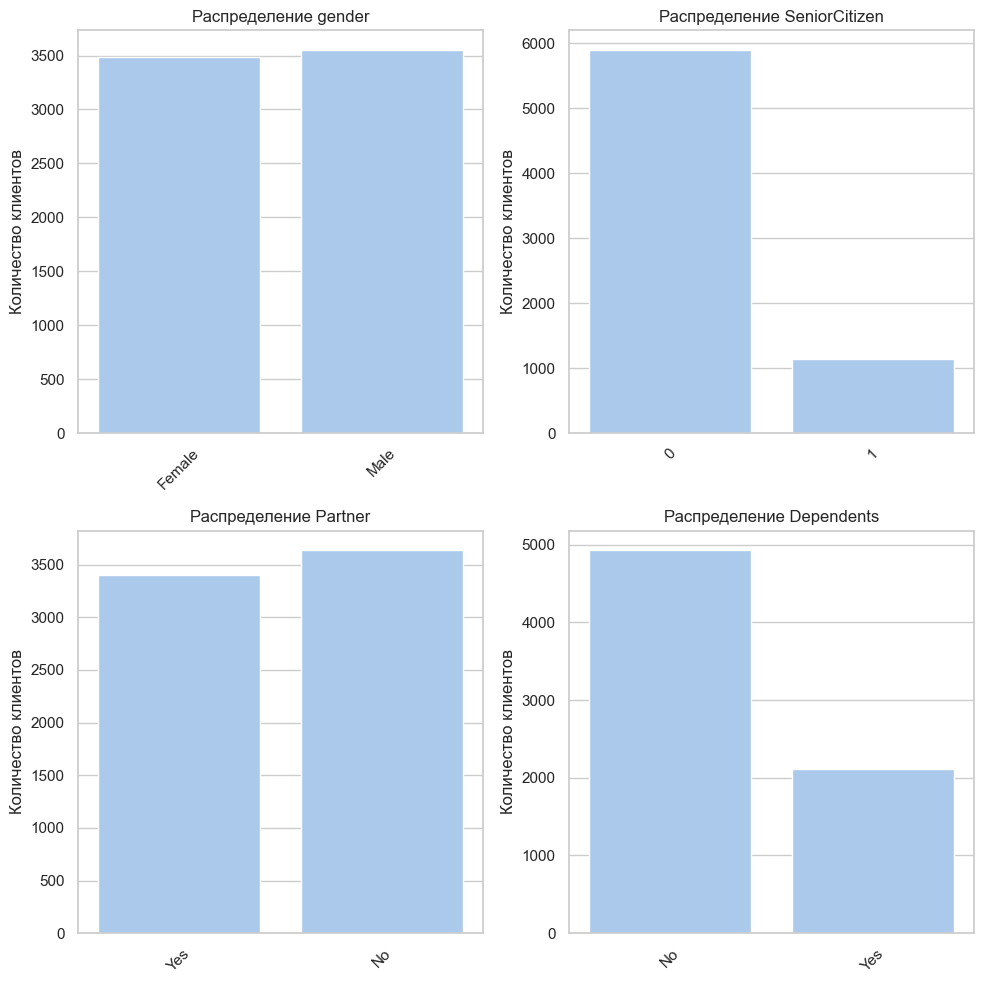

In [42]:
# распределение категориальных признаков
plt.figure(figsize=(10, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df_personal, x=feature)
    plt.title(f'Распределение {feature}')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

* Мужчины и женщины одинаково заключают одинаковое количество договоров
* Людей пенсионного возраста гораздо меньше чем остальных клиентов
* Женатые и одинокие оформляют одинаковое количество договоров
* Людей с иждивенцами примерно в 2.5 раза меньше, чем людей без них

## Таблица internet

In [45]:
# подготовим запрос
query = '''
SELECT 
    *
FROM 
    internet
'''

In [46]:
# загрузим необходимые данные в датафрейм
df_internet = pd.read_sql_query(query, con = engine)

Преобразований делать не нужно, все признаки категориальные

### Визуализация распределения признаков

In [49]:
categorical_features = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

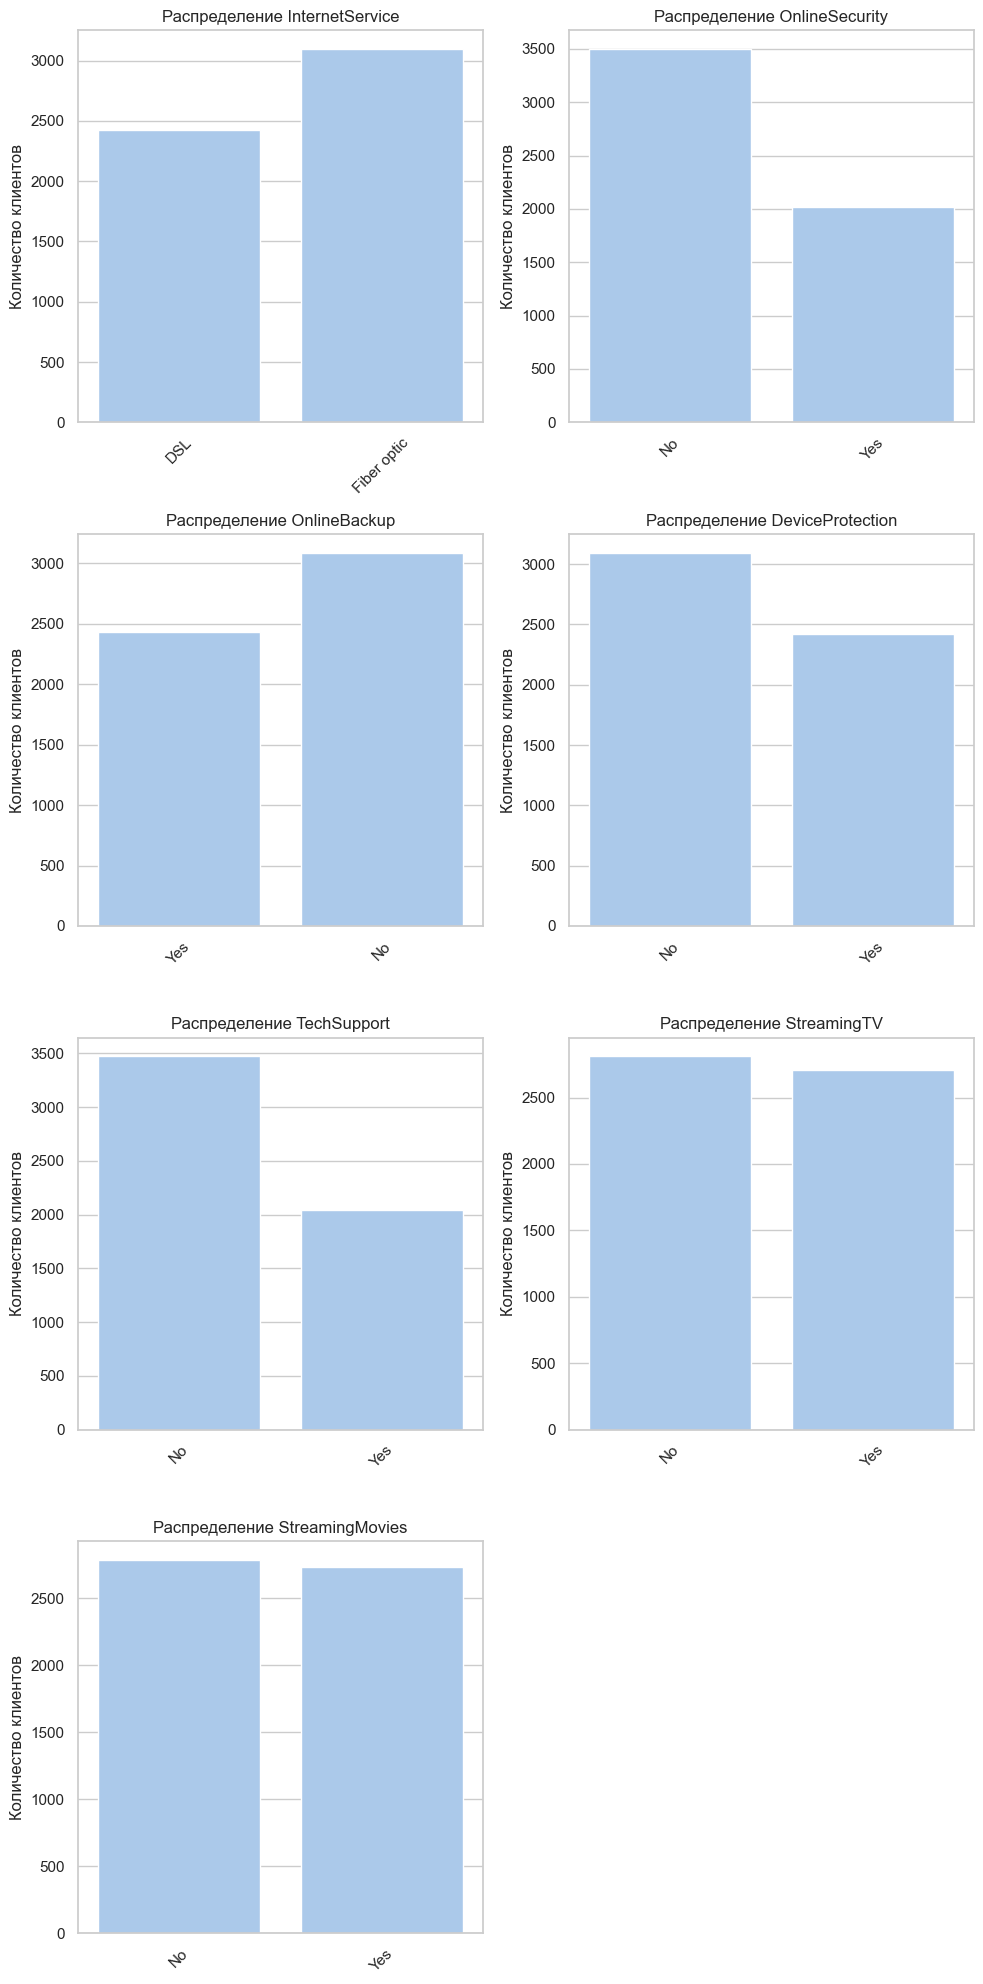

In [50]:
# распределение категориальных признаков
plt.figure(figsize=(10, 20))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(4, 2, i)
    sns.countplot(data=df_internet, x=feature)
    plt.title(f'Распределение {feature}')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

In [51]:
print(f'Количестиво уникальных комбинаций наборов услуг: {len(df_internet[
     ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
 ].apply(lambda x: ''.join(x), axis=1).unique())}')

Количестиво уникальных комбинаций наборов услуг: 64


## Таблица phone

In [53]:
# подготовим запрос
query = '''
SELECT 
    Customerid AS customerID,
    MultipleLines
FROM 
    phone
'''

In [54]:
# загрузим необходимые данные в датафрейм
df_phone = pd.read_sql_query(query, con = engine)
engine.dispose()

### Визуализация распределения признаков

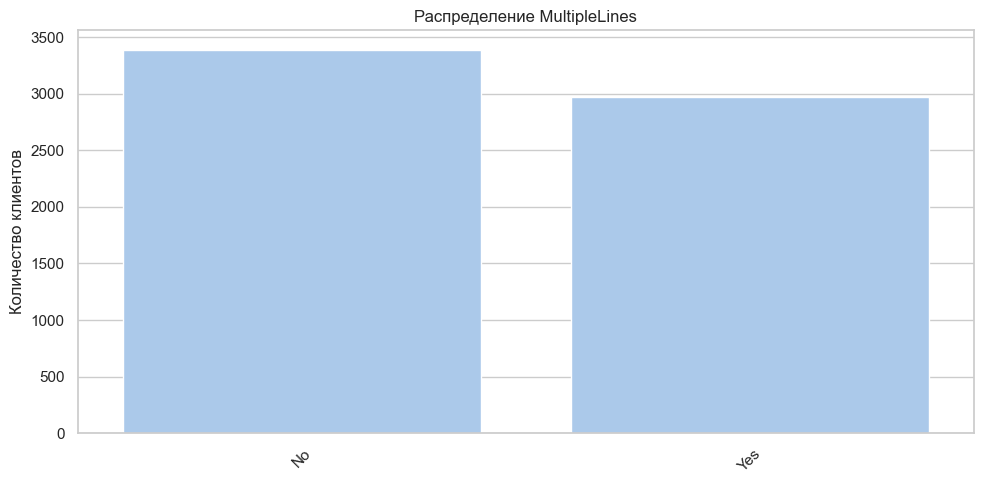

In [56]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_phone, x='MultipleLines')
plt.title(f'Распределение MultipleLines')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

Дисбаланса в распределении услуги нет, данные распределены примерно поровну.

## Объединение датафреймов

In [59]:
# объеденим датафрейемы по идентификатору клиента
df = df_contract.join(
    df_personal.set_index('customerID'), how='left', on='customerID'
).join(
    df_internet.set_index('customerID'), how='left', on='customerID'
).join(
    df_phone.set_index('customerID'), how='left', on='customerID'
)

In [60]:
df = df.set_index('customerID')

In [61]:
# посмотрим размерность датафрейма
df.shape

(7043, 21)

In [62]:
# посмоттрим на общую информацию датафоейма
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   IsCancel          7043 non-null   int64         
 8   DaysActive        7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

* датафреймы `df_contract` и `df_personal` объеденились без образования пропусков, все ID клиентов совпали
* при присоединении датафрейма `df_internet` образовались пропуски, т.к. у части клиентов нет этой услуги. Заполним эти пропуски заглушкой **no_service**.
* такая же картина при присоединении датафрейма `df_phone`. Так же заполним заглушкой.

In [64]:
df = df.fillna('no_service')

### Визуализация распределения признаков на полном наборе данных

Построим визуализации распределение `IsCancel`:
* В зависимости от типа оплаты
* От типа интернет услуг
* От типа телефонной линии
* От семейного положени
* От наличия иждивенцев

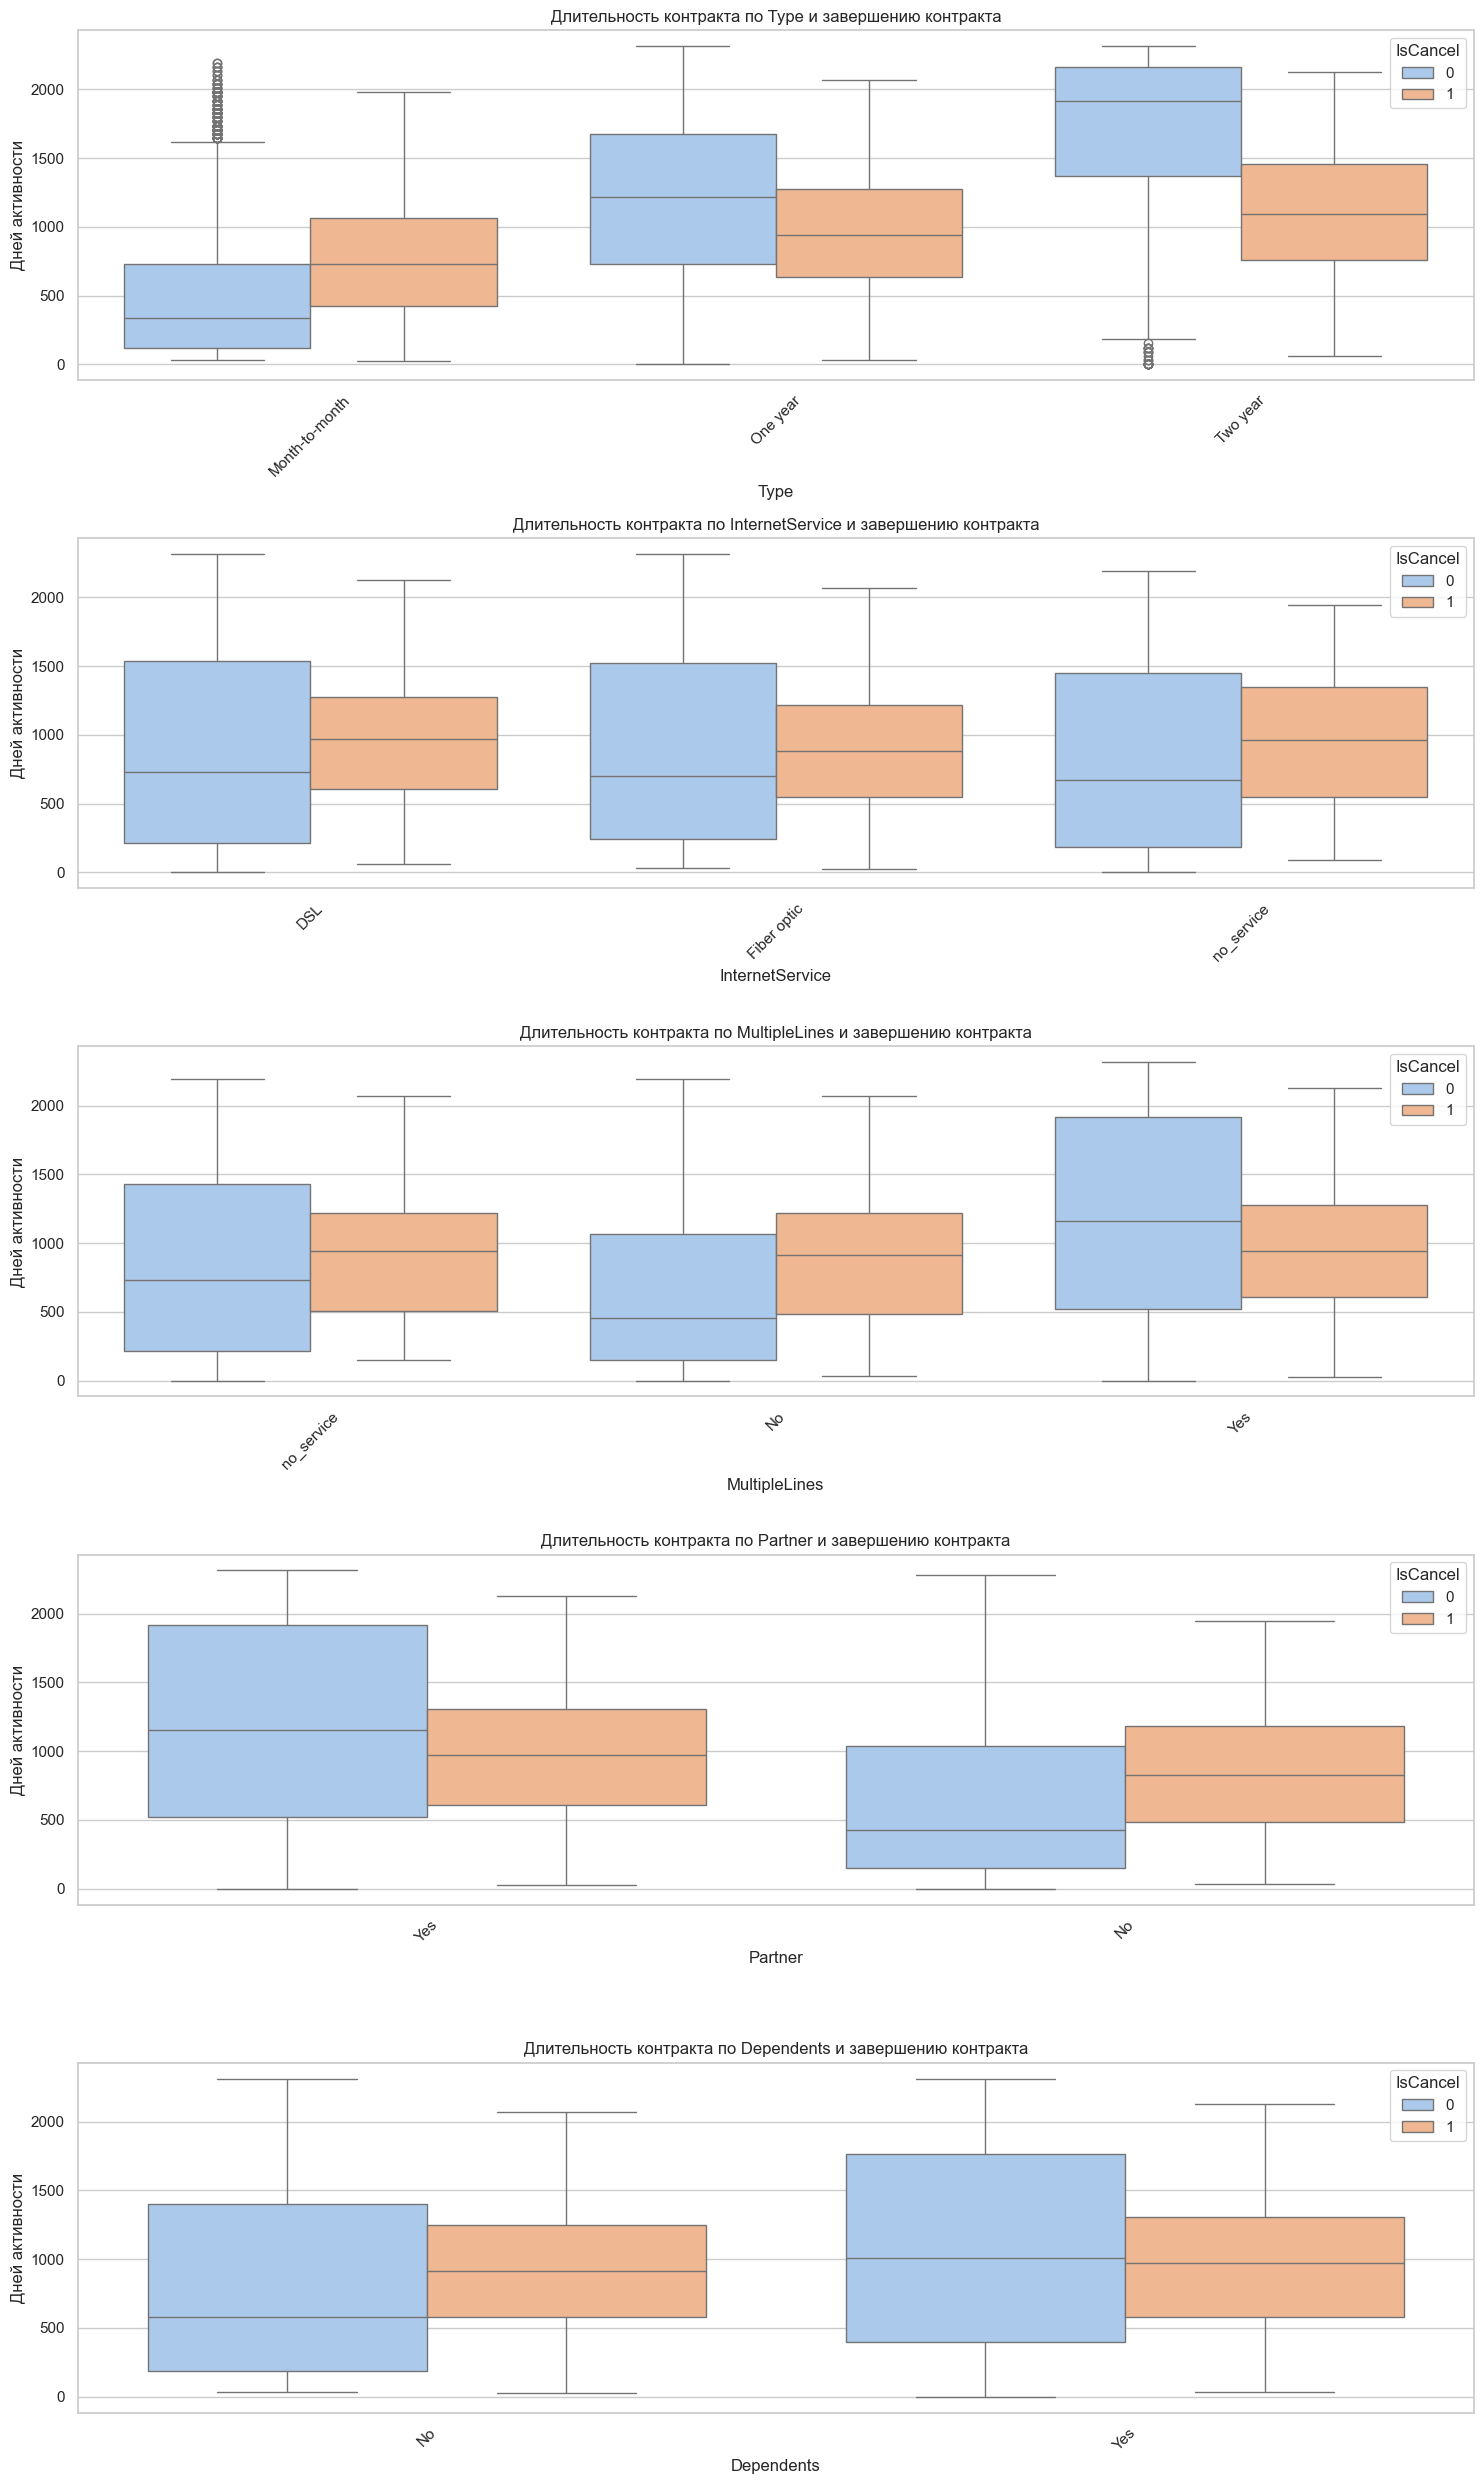

In [67]:
# дополнительные визуализации
plt.figure(figsize=(15, 25))
for i, x in enumerate(['Type', 'InternetService', 'MultipleLines', 'Partner', 'Dependents']):
    plt.subplot(5, 1, i+1)
    sns.boxplot(data=df, x=x, y='DaysActive', hue='IsCancel')
    plt.title(f'Длительность контракта по {x} и завершению контракта')
    plt.xticks(rotation=45)
    plt.xlabel(x)
    plt.ylabel('Дней активности')
plt.tight_layout()
plt.show()

* клиенты использующие помесячный способ оплаты крайне редко задерживаются больше 2х лет
* клиенты использующие двухлетний вариант оплаты, напотив остаются очень долго (5-7 лет)
* по наличию услуги интернет срок действия контракта не сильно отличается, и те у кого подключен интернет (любой тип линии) и те у кого его нет могут расторгнуть договор в период от 2 до 4 лет
* клиенты с нескольктми телефонными линиями задерживаются гораздо дольше чем остальные клиенты
* люди состоящие в браке дольше остаются клиентами
* клиенты с иждивенцами дольше не разравают договор

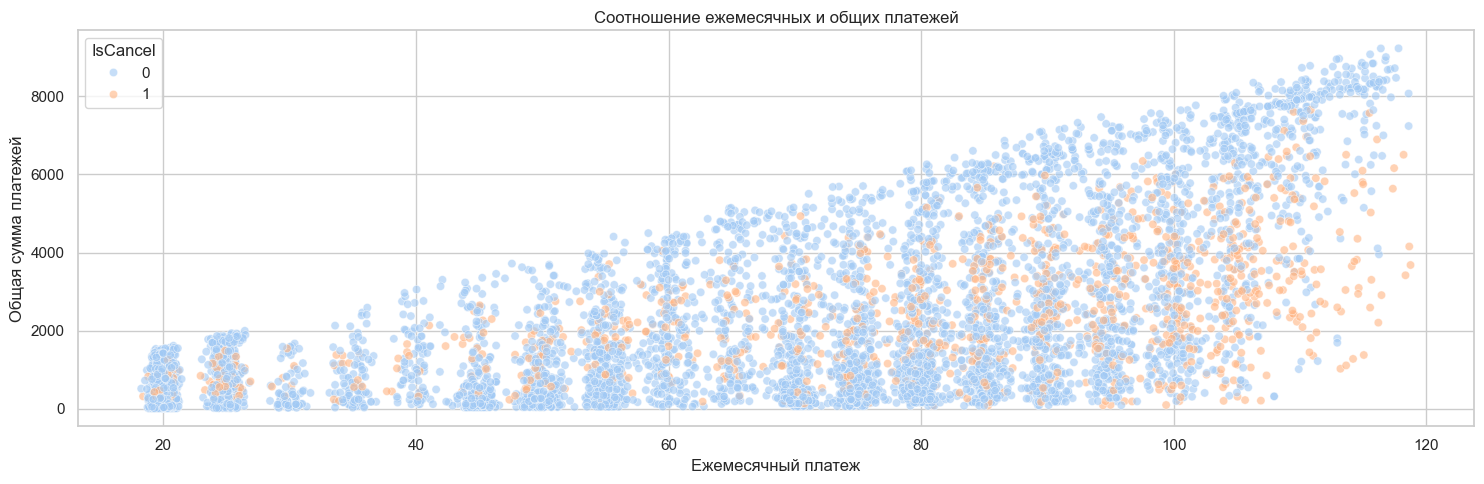

In [69]:
# распределение платежей
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='IsCancel', alpha=0.6)
plt.title('Соотношение ежемесячных и общих платежей')
plt.xlabel('Ежемесячный платеж')
plt.ylabel('Общая сумма платежей')
plt.tight_layout()
plt.show()

Видно, что стоимость услуг не влияет на завершение договора. Как правило, клиенты с большой ежемесячной стоимость продолжают пользовться услугами компании.

## Вывод по разделу:
* Данные подготовлены: даты конвертированы, создан аналитический признак (`DaysActive`) и целевой (`IsCancel`)
* Большинство клиентов используют помесячную оплату
* Наблюдается дисбаланс классов в целевом признаке
* Равномерное гендерное распределение, меньше пенсионеров и клиентов с иждивенцами  
* Интернет-услуги распределены равномерно между DSL и Fiber optic  
* Данные успешно объединены с обработкой пропусков в услугах (пропуски в `TotalCharges` заполнены значением `MonthlyCharges`)
* Наибольшая лояльность у клиентов с длительными контрактами и семейными обязательствами 
* Стоимость услуг не влияет на расторжение договоров  
* Помесячная оплата коррелирует с коротким сроком действия договора

# 3. Корреляционный анализ

Для начала удалим из датафремйа признаки которые мы точно не будем использовать в модели. Это временные признаки `BeginDate` и `EndDate`.

In [74]:
df = df.drop(['BeginDate', 'EndDate'], axis=1)

Определим количественные неприрывные признаки:
* `MonthlyCharge` - число с плавающей точкой
* `TotalCharge` - число с плавающей точкой
* `DaysActive` - целое число с выокой кардинальностью

In [76]:
numeric_features = ['MonthlyCharges', 'TotalCharges', 'DaysActive']

Остальные признаки отнесем к категориальным

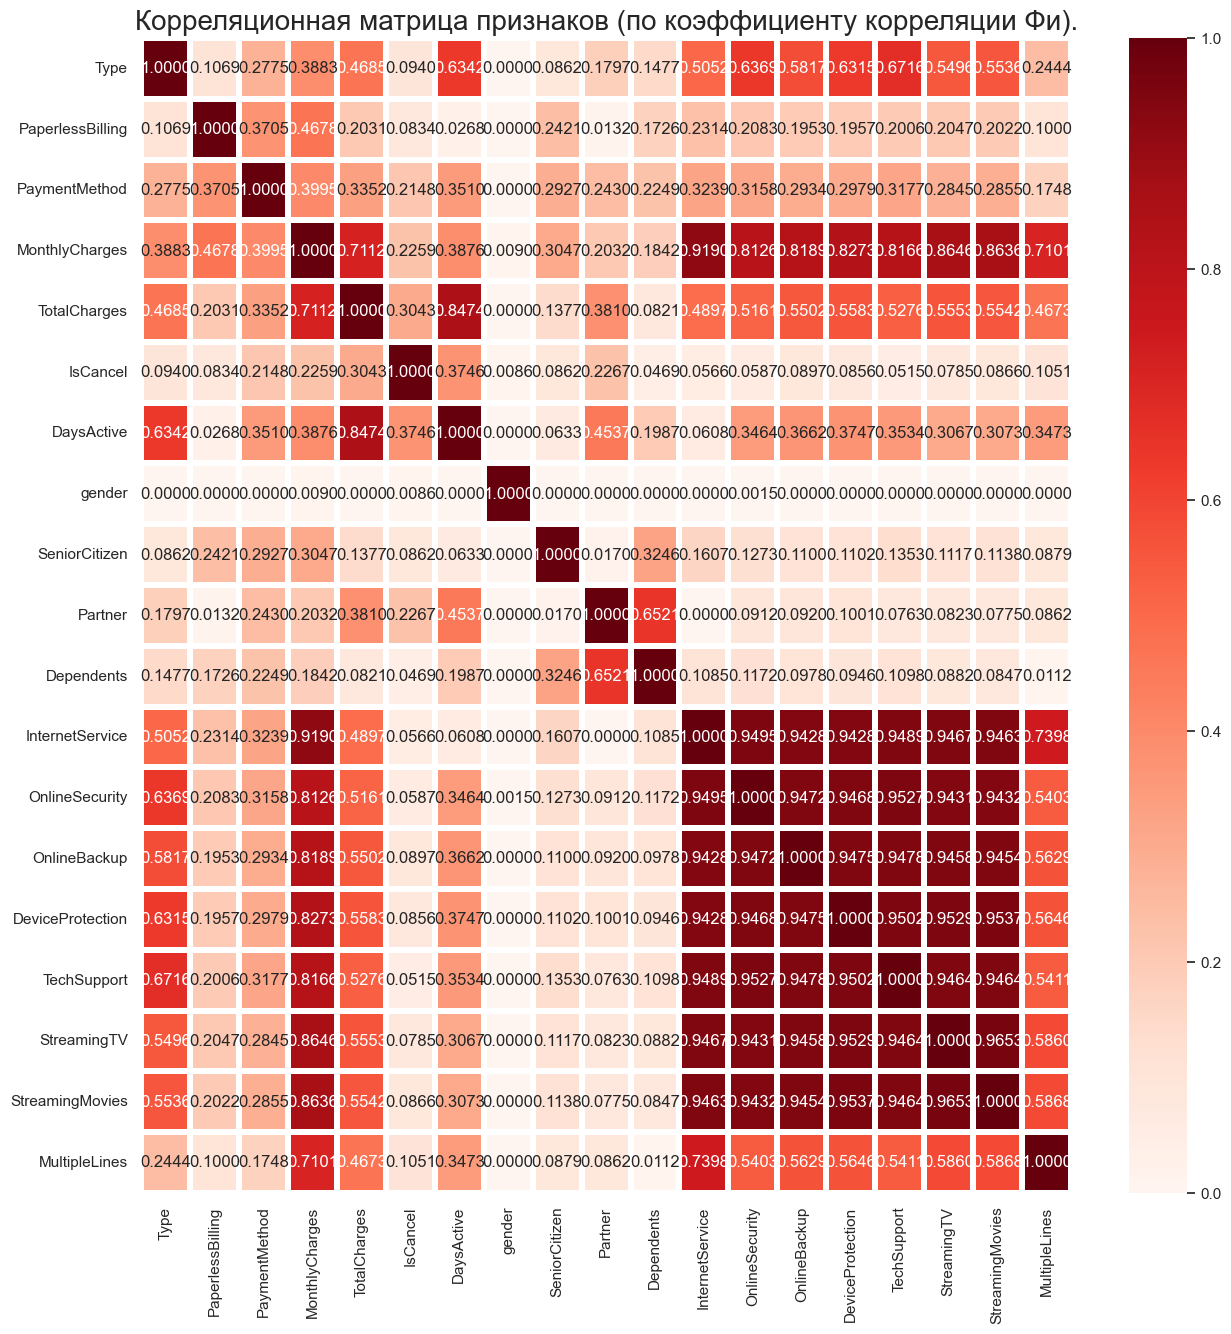

In [78]:
# строим матрицу корреляции
plt.figure(figsize=(15,15))
sns.heatmap(
    df.phik_matrix(
        interval_cols=numeric_features,
        verbose=False
    ),
    annot=True,
    cmap='Reds',
    fmt='.4f',
    linewidths=3
)
plt.title('Корреляционная матрица признаков (по коэффициенту корреляции Фи).', fontsize=20)
plt.show()

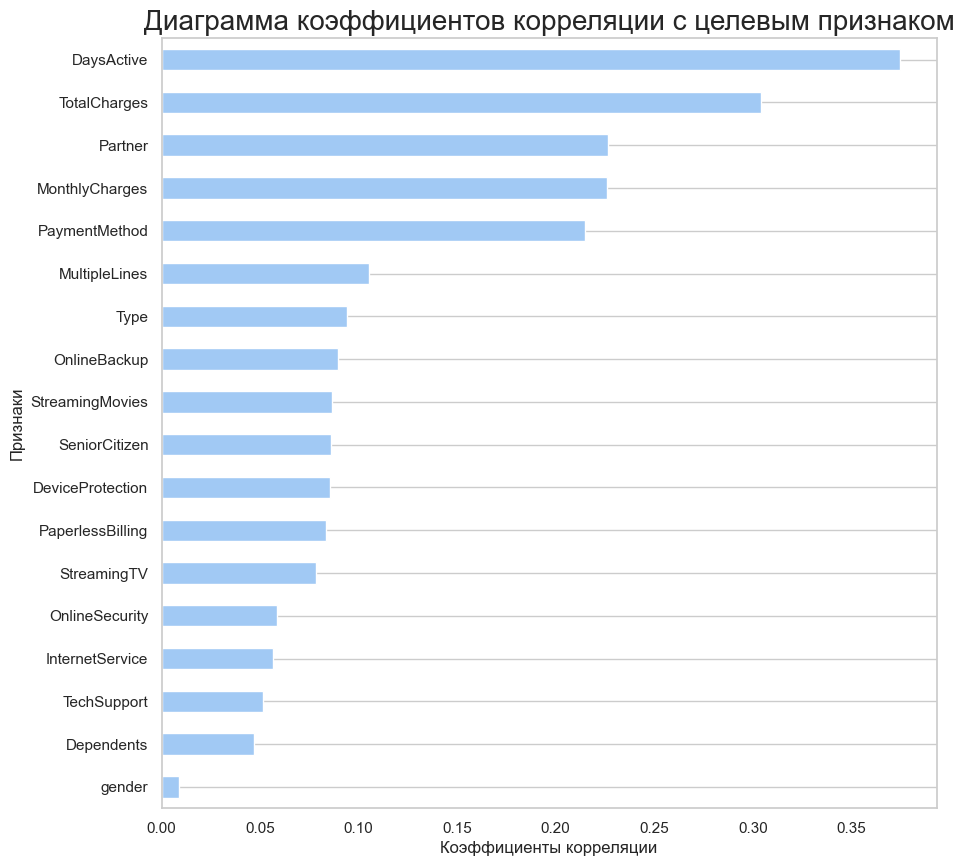

In [79]:
# построим диаграмму коэффициентов корреляции с целевым признаком
plt.figure(figsize=(10,10))
df.phik_matrix(
        interval_cols=numeric_features,
        verbose=False
)[TARGET].sort_values()[:-1].plot.barh()
plt.grid(axis='x')
plt.title('Диаграмма коэффициентов корреляции с целевым признаком', fontsize=20)
plt.xlabel('Коэффициенты корреляции')
plt.ylabel('Признаки')
plt.show()

* Наблюдается мультиколлинеарность интернет услуг между собой, поэтому заменим эти признаки на их сочетание, и назовем дополнительными сервисами.
* Признак `gender` имеет почти нулевую корреляцию со всеми остальными признаками, удалим его
* Саме большие коэффициенты корреляции у `DaysActive` и `TotalCharges`. Ведь если клиент остается лояльным, то срок действия его довора растет и общая сумма платежей тоже. Есть основания пожозревать, что модель будет в основном опираться на эти два признака и игнорировать остальные. На основе этих признаков нужно ввести другие, а эти убрать

Создадим признак дополнительных интернет сервисов.

In [82]:
# создадим признак простым слиянием, а старые признаки удалим
df['additional_services'] = df[
     ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
].apply(lambda x: ''.join(x), axis=1)
df = df.drop(
    ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
    axis=1
)

In [83]:
print(f'Получилось {len(df['additional_services'].unique())} уникальных комбинаций сервисов')

Получилось 65 уникальных комбинаций сервисов


Комбинации получились не очень читаемые, но мы все равно будем их кодировать.

Создадим признак вместо `DaysActive`:
* Возьмем признак `Type` и выразим его в периодичности платежей
    *  `Month-to-month` платеж в среднем раз в 30.44 дня
    *  `One year` - раз в 365.24 дня
    *  `Two year` - раз в 730.48 дней
* Разделив длительность договора на периодичность платежей получим количество платежей которе сделал клиент

In [86]:
def case_pay(value):
    return {
        "Month-to-month": 30.44,
        "One year": 365.24,
        "Two year": 730.48
    }.get(value)

In [87]:
df['pay_count'] = df['DaysActive'] /  df['Type'].apply(case_pay)

Создадим признак изменения у клиента тарифа. Из признака `DaysActive` возьмем количество месяцев и умножим на месячный платеж, если сумма больше `TolalCharges`, то у клиента было измененеи тарифа в сторону повышения, есди меньше - то было понижение, если равно - то изменения тарифа не было.

In [89]:
df['service_change'] = np.select(
    [
        df['DaysActive']/30.44*df['MonthlyCharges'] == df['TotalCharges'],
        df['DaysActive']/30.44*df['MonthlyCharges'] < df['TotalCharges'],
        df['DaysActive']/30.44*df['MonthlyCharges'] > df['TotalCharges']
    ],
    [0, 1, 2]
)

Признаки `DaysActive`, `TotalCharges` и `gender` удалим

In [91]:
df = df.drop(['DaysActive', 'TotalCharges', 'gender'], axis=1)

## Вывод по разделу:
* Построили корреляционную матрицу.
* Наблюдается мультиколлинеарность интернет услуг между собой.
* Признак `gender` имеет почти нулевую корреляцию со всеми остальными признаками.
* Самые большие коэффициенты корреляции у `DaysActive` и `TotalCharges`. Ведь если клиент остается лояльным, то срок действия его довора растет и общая сумма платежей тоже. Есть основания подозревать, что модель будет в основном опираться на эти два признака и игнорировать остальные.
* Создали признак дополнительных интернет сервисов `additional_services`.
* Создадим признак `pay_count` - количество платежей за время дейтсвия договора
* Создали признак `service_change` - было ли изменение тарифа у клиента, если да, то понижение или повышение
* Признаки `DaysActive`, `TotalCharges`, `gender`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `BeginDate` и `EndDate` - удалили


# 4. Обучение моделей

In [94]:
# подготовка выборок
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(TARGET, axis=1),
    df[TARGET],
    test_size=TEST_SIZE,
    stratify = df[TARGET],
    random_state=RANDOM_STATE
)

print(f"Тренировочная выборка: {X_train.shape}, {y_train.shape}")
print(f"Тестовая выборка: {X_test.shape}, {y_test.shape}")

Тренировочная выборка: (5282, 12), (5282,)
Тестовая выборка: (1761, 12), (1761,)


In [95]:
numeric_features = ['MonthlyCharges', 'pay_count', 'service_change']

In [96]:
categorical_features = [x for x in X_train.columns if x not in numeric_features]

In [97]:
# создадим словарь для хранения метрик и времени обучения моделей
best_models = {'model':[], 'ROC-AUC_cv':[],
               'train_time_cv':[], 'ROC-AUC':[],
               'Accuracy':[]}

In [98]:
# функция считает метрику заданной модели на тестовых данных
# и записывает в массив
def get_metrics(X, y, model, metrics_arr, n=3):
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    metrics_arr['ROC-AUC'].append(round(roc_auc, n))
    metrics_arr['Accuracy'].append(round(accuracy, n))
    return metrics_arr

## CatBoostClassifier

In [100]:
# параметры модели CatBoostClassifier
params_grid_cb = {
    'iterations': [250, 350, 450],
    'learning_rate': [.01, .05, .1],
    'depth': [5, 10],
    'verbose': [False],
    'eval_metric': ['AUC'],
    'random_state': [RANDOM_STATE]
}

In [101]:
# Настройка GridSearchCV для CatBoostClassifier
grid_cb = GridSearchCV(
    estimator=CatBoostClassifier(
        cat_features=categorical_features
    ),
    param_grid=params_grid_cb,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

In [102]:
# обучение модели на кросс-валидации + вывод лучших параметров
best_models['model'].append('CatBoostClassifier')
grid_cb.fit(
    X_train,
    y_train
)
best_models['ROC-AUC_cv'].append(grid_cb.best_score_)
best_models['train_time_cv'].append(
    round(grid_cb.cv_results_['mean_fit_time'][grid_cb.best_index_], 4)
)
print('Подобранные гиперпараметры:')
for param, value in grid_cb.best_params_.items():
    print(f'{param}: {value}')

Подобранные гиперпараметры:
depth: 5
eval_metric: AUC
iterations: 450
learning_rate: 0.1
random_state: 110825
verbose: False


In [103]:
# выбираем лучшую обученную модель
best_model_cb = grid_cb.best_estimator_

In [104]:
# оцениваем модель на тестовых данных
best_models = get_metrics(X_test, y_test, best_model_cb, best_models)

## LogisiticRegression

In [106]:
# пайплайн для OHE кодирования признаков. пропуски заменям модой.
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [107]:
# пайплайн для масштабирования количественных признаков, пропуски заполеям медианой
num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [108]:
# пайплайн для кодирования и масштабирования всех признаков
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, categorical_features),
        ('num', num_pipe, numeric_features)
    ], 
    remainder='passthrough'
)

In [109]:
# финальный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
) 

In [110]:
param_grid_lr = [    
    {
        'models': [
            LogisticRegression()
        ],
        'models__C': [0.1, 1, 10],
        'models__penalty': ['l2'],
        'models__solver': ['lbfgs', 'liblinear'],
        'models__class_weight': ['balanced']
    }
]

In [111]:
# Настройка GridSearchCV для LinearRegression
grid_lr = GridSearchCV(
    pipe_final,
    param_grid_lr,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

In [112]:
# обучение модели на кросс-валидации + вывод лучших параметров
best_models['model'].append('LogisticRegression')
grid_lr.fit(
    X_train,
    y_train
)
best_models['ROC-AUC_cv'].append(grid_lr.best_score_)
best_models['train_time_cv'].append(
    round(grid_lr.cv_results_['mean_fit_time'][grid_lr.best_index_], 4)
)
print('Подобранные гиперпараметры:')
for param, value in grid_lr.best_params_.items():
    print(f'{param}: {value}')

Подобранные гиперпараметры:
models: LogisticRegression()
models__C: 0.1
models__class_weight: balanced
models__penalty: l2
models__solver: lbfgs


In [113]:
# выбираем лучшую обученную модель
best_model_lr = grid_lr.best_estimator_

In [114]:
# оцениваем модель на тестовых данных
best_models = get_metrics(X_test, y_test, best_model_lr, best_models)

## RandomForestClassifier

In [116]:
# параметры модели RandomForestClassifier
param_grid_rf = [
    {
        'models': [
            RandomForestClassifier(random_state=RANDOM_STATE)
        ],
        'models__n_estimators': [200, 300, 350],
        'models__max_depth': [5, 8, 10],
        'models__min_samples_split': [5, 10, 15],
        'models__min_samples_leaf': [2, 4],
        'models__class_weight': ['balanced']
    }
]     

In [117]:
# Настройка GridSearchCV для RandomForestClassifier
grid_rf = GridSearchCV(
    pipe_final,
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [118]:
# обучение модели на кросс-валидации + вывод лучших параметров
best_models['model'].append('RandomForestClassifier')
grid_rf.fit(
    X_train,
    y_train
)
best_models['ROC-AUC_cv'].append(grid_rf.best_score_)
best_models['train_time_cv'].append(
    round(grid_rf.cv_results_['mean_fit_time'][grid_rf.best_index_], 4)
)
print('Подобранные гиперпараметры:')
for param, value in grid_rf.best_params_.items():
    print(f'{param}: {value}')

Подобранные гиперпараметры:
models: RandomForestClassifier(random_state=110825)
models__class_weight: balanced
models__max_depth: 10
models__min_samples_leaf: 2
models__min_samples_split: 15
models__n_estimators: 300


In [119]:
# выбираем лучшую обученную модель
best_model_rf = grid_rf.best_estimator_

In [120]:
# оцениваем модель на тестовых данных
best_models = get_metrics(X_test, y_test, best_model_rf, best_models)

## DummyClassifier

In [122]:
# делаем проверку на адекватность
best_models['model'].append('DummyClassifier')
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(
    X_train,
    y_train
)
best_models['ROC-AUC_cv'].append(0)
best_models['train_time_cv'].append(0)

In [123]:
# оцениваем модель на тестовых данных
best_models = get_metrics(X_test, y_test, dummy, best_models)

## Нeйросеть

In [125]:
# построим нейросеть
def NN_train(X_train, y_train, validation_split=.25, 
                         class_weight=None, verbose=1):

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='roc_auc')]
    )
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    
    model.fit(
        X_train,
        y_train,
        validation_split=validation_split,
        epochs=50,
        batch_size=64,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=verbose
    )
    
    return model

In [126]:
# трансформируем входные признаки
X_train_transform = pipe_final.fit_transform(X_train)
X_test_transform = pipe_final.transform(X_test)

In [127]:
model_nn = NN_train(
    X_train=X_train_transform,
    y_train=y_train,
    class_weight={0: 1, 1: 5}, 
    verbose=1
)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2915 - roc_auc: 0.6245 - val_loss: 0.6039 - val_roc_auc: 0.6940
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0400 - roc_auc: 0.7386 - val_loss: 0.5577 - val_roc_auc: 0.7212
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9597 - roc_auc: 0.7443 - val_loss: 0.5324 - val_roc_auc: 0.7177
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9356 - roc_auc: 0.7632 - val_loss: 0.5156 - val_roc_auc: 0.7358
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9195 - roc_auc: 0.7867 - val_loss: 0.5058 - val_roc_auc: 0.7234
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9317 - roc_auc: 0.7766 - val_loss: 0.4965 - val_roc_auc: 0.7281
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8720 - roc_auc: 0.7974 - val_loss: 0.5106 - val_roc_auc: 0.7257
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8370 - roc_auc: 0.8187 - val_loss: 0.5069 - val_roc_auc: 0.7259
Epoch 9/

In [128]:
y_proba = model_nn.predict(X_test_transform)
roc_auc_nn = roc_auc_score(y_test, y_proba)
print(f'Метрика ROC-AUC на тесте: {roc_auc_nn:.4f}')
if roc_auc_nn < TARGET_METRIC:
    print('Модель не походит, слишком слабая метрика')
else:
    print('Это просто ЧуДО!!')

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Метрика ROC-AUC на тесте: 0.7154
Модель не походит, слишком слабая метрика


## Вывод по разделу:
* Разделили данные на тренировочную и тестовую выборки
* Провели обучение моделей `CatBoostClassifier`, `LogisiticRegression`, `RandomForestClassifier`, `DummyClassifier` и нейросеть.
* Получили и сохранили метрики на тестовых данных.
* Сразу же отказались от нейросети, т.к. она показала метрику ниже целевой.

# 5. Тестирование лучшей модели

In [131]:
# создаем датафрейм с метриками моделей
models_results = pd.DataFrame(
    best_models, columns=[
        'model', 'ROC-AUC_cv',
        'train_time_cv', 'ROC-AUC',
        'Accuracy'
    ]
)

In [132]:
print('Лучшая модель:')
models_results.sort_values(by='ROC-AUC_cv', ascending=False).iloc[0]

Лучшая модель:


model            CatBoostClassifier
ROC-AUC_cv                 0.856948
train_time_cv               22.2826
ROC-AUC                       0.865
Accuracy                      0.881
Name: 0, dtype: object

In [133]:
# Выведем для сравнения метрики всех моделей
models_results

,model,ROC-AUC_cv,train_time_cv,ROC-AUC,Accuracy
0,CatBoostClassifier,0.856948,22.2826,0.865,0.881
1,LogisticRegression,0.736720,0.0728,0.740,0.668
2,RandomForestClassifier,0.820373,1.2556,0.814,0.791
3,DummyClassifier,0.000000,0.0000,0.500,0.844


Лучшей моделью оказалась `CatBoostClassifier` c метрикой ROC-AUC на тестовых данных `0.865`

In [135]:
# выбираем CatBoost в качестве финальной модели
best_model = grid_cb.best_estimator_

Для лучшей модели построим матрицу ошибок.

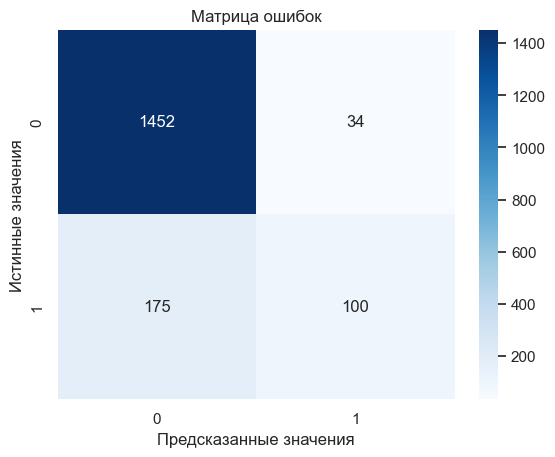

In [137]:
# посмтроим матрицу ошибок
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_test_proba)
accuracy = accuracy_score(y_test, y_test_pred)

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

* с определение TN у модели все хорошо
* а TP она определила только 36% 

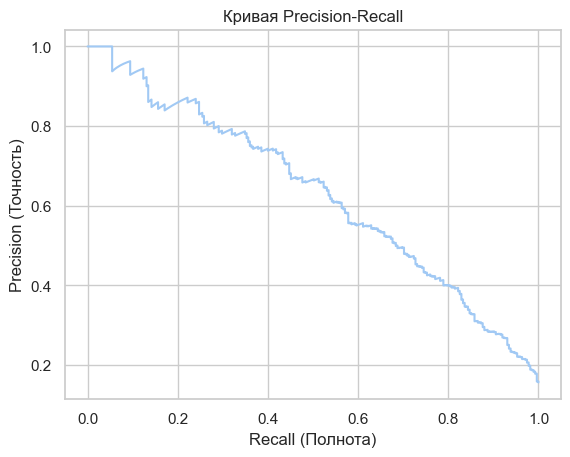

In [139]:
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
plt.plot(recall, precision)
plt.title('Кривая Precision-Recall')
plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.show()

Кривая выглядит не слишком хорошо, без настройки порогов модель будет предсказыать не сильно лучше дамми модели.

## Выводы по разделу:
* Выбрали лучшую модель `CatBoostClassifier` с метрикой `ROC-AUC - 0.865`
* Построили митрицу ошибок, модель хорошо предсказыает нулевой класс и не очень хорошо первый
* Кривая `Precission-Recall` слишком близка к линейной

# 6. Анализ важности признаков

In [143]:
# инициализация
explainer = shap.TreeExplainer(best_model)

In [144]:
# создание формата категориальных данных для CatBoost
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

In [145]:
# получение SHAP значений
shap_values = explainer.shap_values(test_pool)

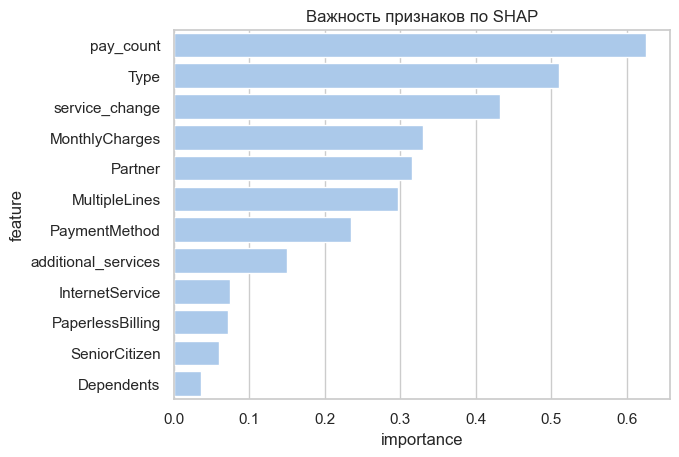

In [146]:
# отбираем признаки по важности и строим график
shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

plt.title('Важность признаков по SHAP')
sns.barplot(x='importance', y='feature', data=shap_df.head(20))
plt.show()

Наиболее важные признаки для модели `pay_count` и `Type`. Проведем их дополнительный анализ.

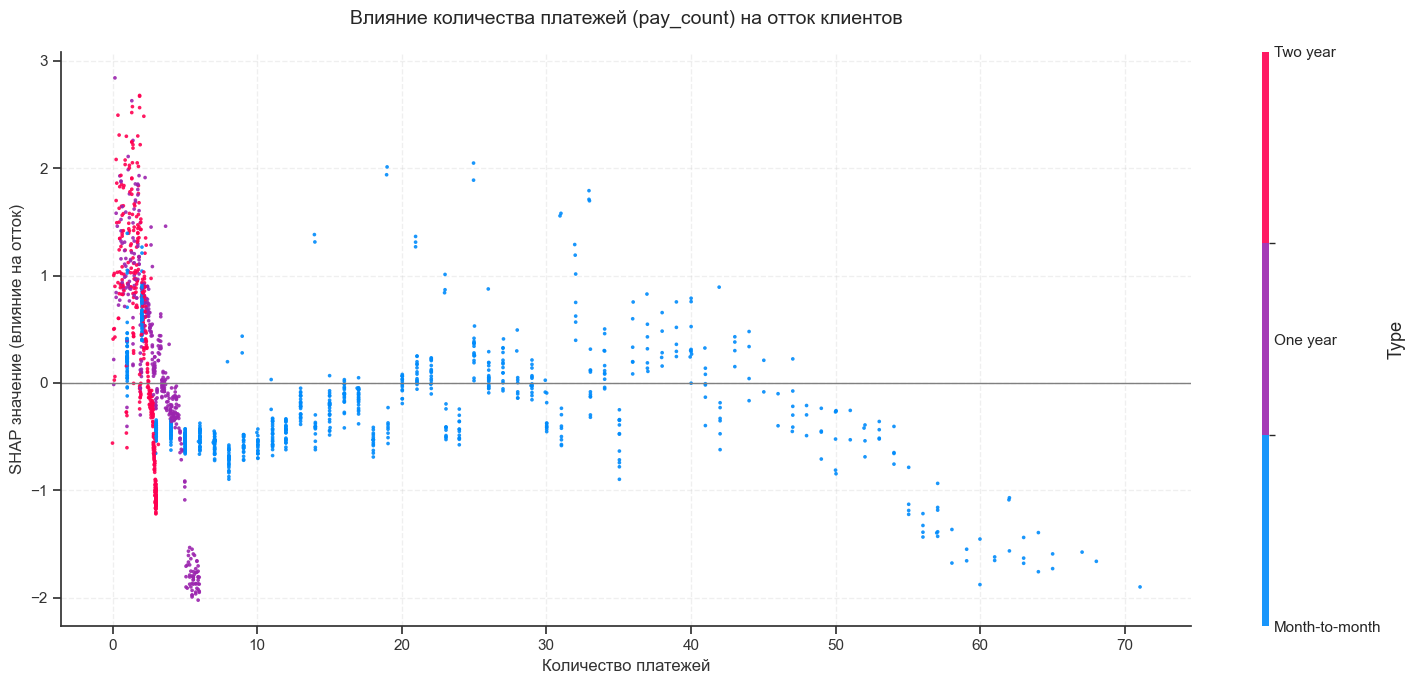

In [148]:
# Создаем фигуру и оси явно
fig, ax = plt.subplots(figsize=(15, 7))

shap.dependence_plot(
    ind='pay_count',
    shap_values=shap_values,
    features=X_test,
    interaction_index='Type',
    dot_size=7,
    alpha=0.9,
    ax=ax,
    show=False
)

ax.set_title('Влияние количества платежей (pay_count) на отток клиентов', 
            fontsize=14, pad=20)
ax.set_xlabel('Количество платежей', fontsize=12)
ax.set_ylabel('SHAP значение (влияние на отток)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()

* Более всего на отток клиентов влияет мало количество платежей
* В основном это клиенты с оплатой за год и за два года
* Так же есть некоторе количество клиентов с помесячной оплатой

## Выводы по разделу:
* Построили визуализацию оценки важности призгаков по SHAP
* Наиболее важными признаками оказались `pay_count` (количество платежей за период действия договора) и `Type` (тип оплаты)
* Провели дополнительное исследование влияния этих признаков:
    * Более всего на отток клиентов влияет мало количество платежей
    * В основном это клиенты с оплатой за год и за два года

# 7. Общий вывод
* Реализован анализ структуры БД с проверкой таблиц и типов данных.
* Подготовлены данные: конвертированы даты, созданы аналитические признаки.
* Выявлен дисбаланс классов.
* Удалены нерелевантные признаки и добавлены новые для улучшения модели.
* Обучены модели, лучшая — `CatBoostClassifier` с метрикой ROC-AUC: 0.865.
* Модель хорошо предсказывает лояльных клиентов, но хуже — уходящих.
* Ключевые признаки: `pay_count` и `Type`.

**Рекомендации**
1. На основании проделанной работы можно предположить, что уходят клиенты с "длинными" договорами, примерно после 2-3 оплаты.
2. Таким клиентам предлагается предоставлять скидку на следующее продление договора, т.о. можно будет удержать их еще на 1-2 года.